## precipitation extremes (pr)

In [1]:
import intake
import xarray as xr
import xesmf as xe

import numpy as np
import skimage.measure as skm

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import os

from regridder import calc_regridb


In [2]:
#import dask
#dask.config.set(**{'array.slicing.split_large_chunks': True})

## precipitation data

In [3]:
# rmodel to regrid to
ds_dict = intake.cat.nci['esgf'].cmip5.search(
                                        model_id = 'FGOALS-g2', 
                                        experiment = 'historical',
                                        time_frequency = 'day', 
                                        realm = 'atmos', 
                                        ensemble = 'r1i1p1', 
                                        variable= 'pr').to_dataset_dict()

ds_regrid = ds_dict[list(ds_dict.keys())[-1]].sel(time='1970-01-01', lon=slice(0,360),lat=slice(-30,30))
ds_regrid


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.product.institute_id.model_id.experiment.time_frequency.realm.cmor_table.ensemble.version.variable'


<xarray.Dataset>
Dimensions:    (time: 1, bnds: 2, lat: 22, lon: 128)
Coordinates:
  * time       (time) object 1970-01-01 12:00:00
  * lat        (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 23.72 26.51 29.3
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 -30.7 -27.91 -27.91 ... 27.91 27.91 30.7
    lon_bnds   (lon, bnds) float64 -1.406 1.406 1.406 ... 355.8 355.8 358.6
    pr         (time, lat, lon) float32 dask.array<chunksize=(1, 22, 128), meta=np.ndarray>
Attributes: (12/29)
    initialization_method:   1
    intake_esm_varname:      ['pr']
    frequency:               day
    experiment:              historical
    project_id:              CMIP5
    parent_experiment_rip:   r1i1p1
    ...                      ...
    source:                  FGOALS_g2 2011 atmosphere: GAMIL (gamil2, 128x60...
    table_id:                Table day (26 July 2011) f21c16b785432e6bd3f72e8...
    Conventions:             CF-1.4
    experiment_id:           historical
    product:                 output
    intake_esm_dataset_key:  cmip5.output1.LASG-CESS.FGOALS-g2.historical.day...

In [4]:
models = [
        # 'IPSL-CM5A-MR', # 1
        # 'GFDL-CM3',     # 2
        # 'GISS-E2-H',    # 3
        # 'bcc-csm1-1',   # 4
        # 'CNRM-CM5',     # 5
        # 'CCSM4',        # 6 # cannot concatanate files for historical
        # 'HadGEM2-AO',   # 7
        # 'BNU-ESM',      # 8
        # 'EC-EARTH',     # 9
        # 'FGOALS-g2',    # 10
        # 'MPI-ESM-MR',   # 11
        # 'CMCC-CM',      # 12
        # 'inmcm4',       # 13 # did not save
        # 'NorESM1-M',    # 14
        # 'CanESM2',      # 15 # slicing with .sel does not work, 'contains no datetime objects'
        # 'MIROC5',       # 16
         'HadGEM2-CC',   # 17
        # 'MRI-CGCM3',    # 18
        # 'CESM1-BGC'     # 19
        ]

model = models[0] #'GFDL-CM3'


In [5]:
historical = False
rcp85 = True

if historical:
    experiment = 'historical'
    period=slice('1970-01','1999-12')
    ensemble = 'r1i1p1'

    if model == 'GISS-E2-H':
        ensemble = 'r6i1p1'


if rcp85:
    experiment = 'rcp85'
    period=slice('2070-01','2099-12')
    ensemble = 'r1i1p1'

    if model == 'GISS-E2-H':
        ensemble = 'r2i1p1'

In [ ]:
subset = intake.cat.nci['esgf'].cmip5.search(
                                            model_id = model, 
                                            experiment = experiment,
                                            time_frequency = 'day', 
                                            realm = 'atmos', 
                                            ensemble = ensemble, 
                                            variable= 'pr'
)
subset

: 

: 

In [ ]:
ds_dict = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.product.institute_id.model_id.experiment.time_frequency.realm.cmor_table.ensemble.version.variable'


In [ ]:
# ds_orig.isel(time=slice(43800, 43800+10950)).sel(lon=slice(0,360),lat=slice(-30,30))

In [ ]:
if not model == 'CanESM2':
    ds_orig =ds_dict[list(ds_dict.keys())[-1]].sel(time=period, lon=slice(0,360),lat=slice(-30,30))
else:
    ds_orig =ds_dict[list(ds_dict.keys())[-1]].isel(time=slice(43800, 43800+10950)).sel(lon=slice(0,360),lat=slice(-30,30))


In [ ]:
ds_orig

<xarray.Dataset>
Dimensions:    (time: 10950, bnds: 2, lat: 42, lon: 256)
Coordinates:
  * time       (time) object 2070-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lat        (lat) float64 -28.72 -27.31 -25.91 -24.51 ... 25.91 27.31 28.72
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(3650, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 -29.42 -28.02 -28.02 ... 28.02 28.02 29.42
    lon_bnds   (lon, bnds) float64 -0.7031 0.7031 0.7031 ... 357.9 357.9 359.3
    pr         (time, lat, lon) float32 dask.array<chunksize=(3650, 42, 256), meta=np.ndarray>
Attributes: (12/29)
    institute_id:            MIROC
    realization:             1
    contact:                 Masahiro Watanabe (hiro@aori.u-tokyo.ac.jp), Sei...
    source:                  MIROC5 2010 atmosphere: MIROC-AGCM6 (T85L40); oc...
    project_id:              CMIP5
    intake_esm_varname:      ['pr']
    ...                      ...
    product:                 output
    tracking_id:             04757b3d-ef3d-441b-8f35-9792d70cfb97\n62d81948-f...
    experiment:              RCP8.5
    frequency:               day
    physics_version:         1
    intake_esm_dataset_key:  cmip5.output1.MIROC.MIROC5.rcp85.day.atmos.day.r...

In [ ]:
#xe.Regridder(ds_orig, ds_regrid, 'conservative', periodic=True)

In [ ]:
# apply regridding
haveWeights = False
ds_pr = calc_regrid(ds_orig, ds_regrid, haveWeights, model)

In [ ]:
ds_pr

<xarray.Dataset>
Dimensions:  (time: 10950, lat: 22, lon: 128)
Coordinates:
  * time     (time) object 2070-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(3650, 22, 128), meta=np.ndarray>
Attributes:
    regrid_method:  conservative

In [ ]:
# remove missing values
print(ds_pr.pr.encoding)
ds_pr = ds_pr.where(ds_pr.pr < 1e+20) 

{}


In [ ]:
precip = ds_pr.pr*60*60*24
precip.attrs['units']= 'mm/day'
precip

<xarray.DataArray 'pr' (time: 10950, lat: 22, lon: 128)>
dask.array<mul, shape=(10950, 22, 128), dtype=float32, chunksize=(3650, 22, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2070-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:    mm/day

## snapshot

In [ ]:
pr_day = precip.isel(time=0)
pr_4days = precip.isel(time=slice(0, 4))

lat = pr_day.lat
lon = pr_day.lon

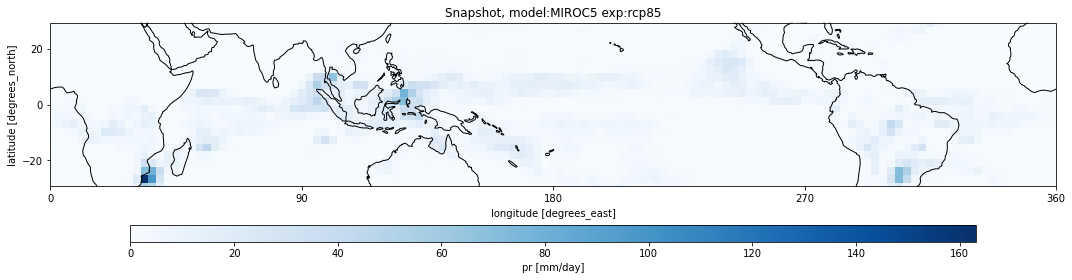

In [ ]:
projection = ccrs.PlateCarree(central_longitude=180)

f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(15, 5))

pr_day.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap='Blues')
ax.add_feature(cfeat.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax.set_title('Snapshot, model:' + model + ' exp:' + experiment)
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])
ax.set_yticks([-20, 0, 20])
plt.tight_layout()

# O.plot(transform=ccrs.PlateCarree(), levels =4, colors = ['w','c','k'], add_colorbar=False) 
# ax1.add_feature(cfeat.COASTLINE)
# ax1.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
# ax1.set_title('Snapshot of objects, model:' + model + ' exp:' + experiment)
# ax1.set_xticks([-180, -90, 0, 90, 180])
# ax1.set_xticklabels([0, 90, 180, 270, 360])
# ax1.set_yticks([-20, 0, 20])



save = False
if save:
    plt.savefig('/g/data/k10/cb4968/phd/cmip5_scripts/snapshot.pdf') #,transparent=True) 


## time mean precipitation

In [ ]:
pr_tMean= precip.mean(dim='time', keep_attrs=True)

# areaweighting
# weights = np.cos(np.deg2rad(lat))$
# weights.name = "weights"
# pr_tMean.weighted(weights).mean(dim=('lat','lon'))

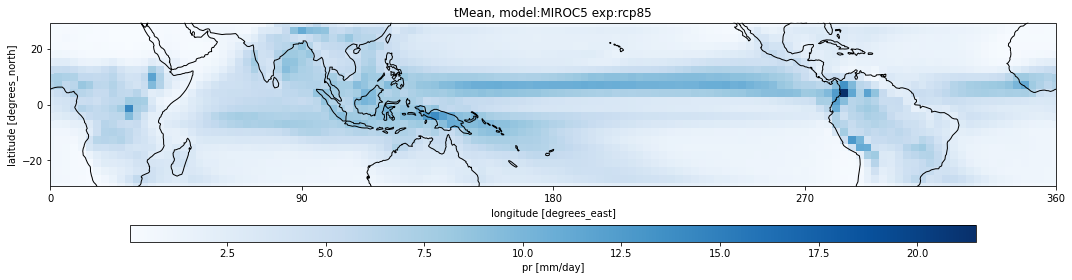

In [ ]:
# plot timeMean
projection = ccrs.PlateCarree(central_longitude=180)

f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(15, 5))

pr_tMean.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap='Blues')
ax.add_feature(cfeat.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax.set_title('tMean, model:' + model + ' exp:' + experiment)
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])
ax.set_yticks([-20, 0, 20])
plt.tight_layout()

## rx1day, rx5day 

In [ ]:
rx1day = precip.resample(time='Y').max(dim='time')

precip5day = precip.resample(time='5D').mean(dim='time')
rx5day = precip5day.resample(time='Y').max(dim='time')

In [ ]:
# take time mean
rx1day_tMean = rx1day.mean(dim=('time'),keep_attrs=True)
rx5day_tMean = rx5day.mean(dim=('time'),keep_attrs=True)

# take spatial mean
rx1day_sMean = rx1day.mean(dim=('lat','lon'),keep_attrs=True)
rx5day_sMean = rx5day.mean(dim=('lat','lon'),keep_attrs=True)

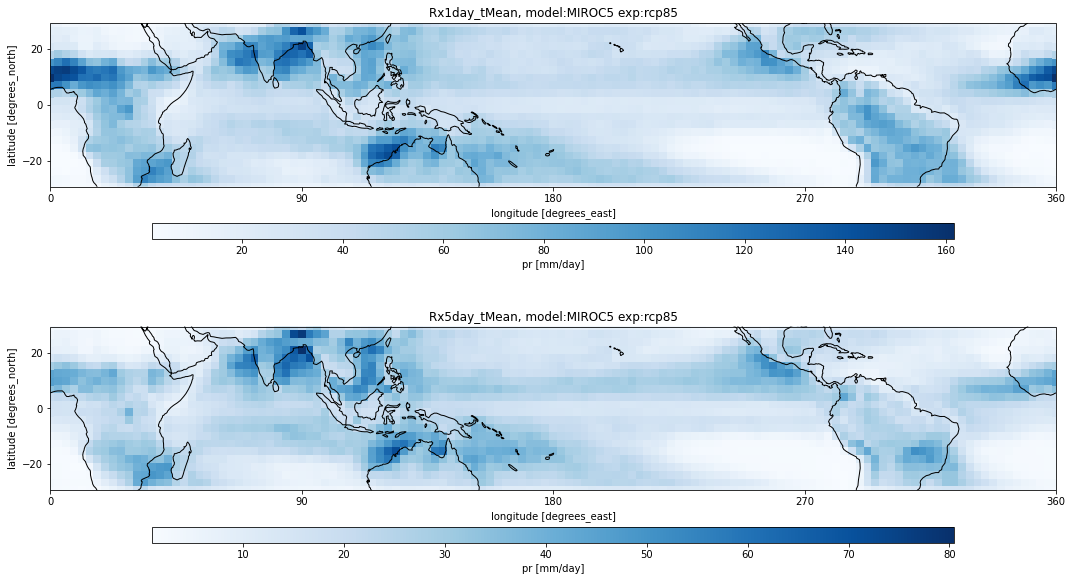

In [ ]:
# plot tMean Rx1day and Rx5day
projection = ccrs.PlateCarree(central_longitude=180)

f, (ax1, ax2) = plt.subplots(nrows = 2, subplot_kw=dict(projection=projection), figsize=(15, 9))

# Rx1day
rx1day_tMean.plot(ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055},cmap='Blues')
ax1.add_feature(cfeat.COASTLINE)
ax1.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax1.set_title('Rx1day_tMean, model:' + model + ' exp:' + experiment)
ax1.set_xticks([-180, -90, 0, 90, 180])
ax1.set_xticklabels([0, 90, 180, 270, 360])
ax1.set_yticks([-20, 0, 20])

# Rx5day
rx5day_tMean.plot(ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055},cmap='Blues')
ax2.add_feature(cfeat.COASTLINE)
ax2.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax2.set_title('Rx5day_tMean, model:' + model + ' exp:' + experiment)
ax2.set_xticks([-180, -90, 0, 90, 180])
ax2.set_xticklabels([0, 90, 180, 270, 360])
ax2.set_yticks([-20, 0, 20])

plt.tight_layout()



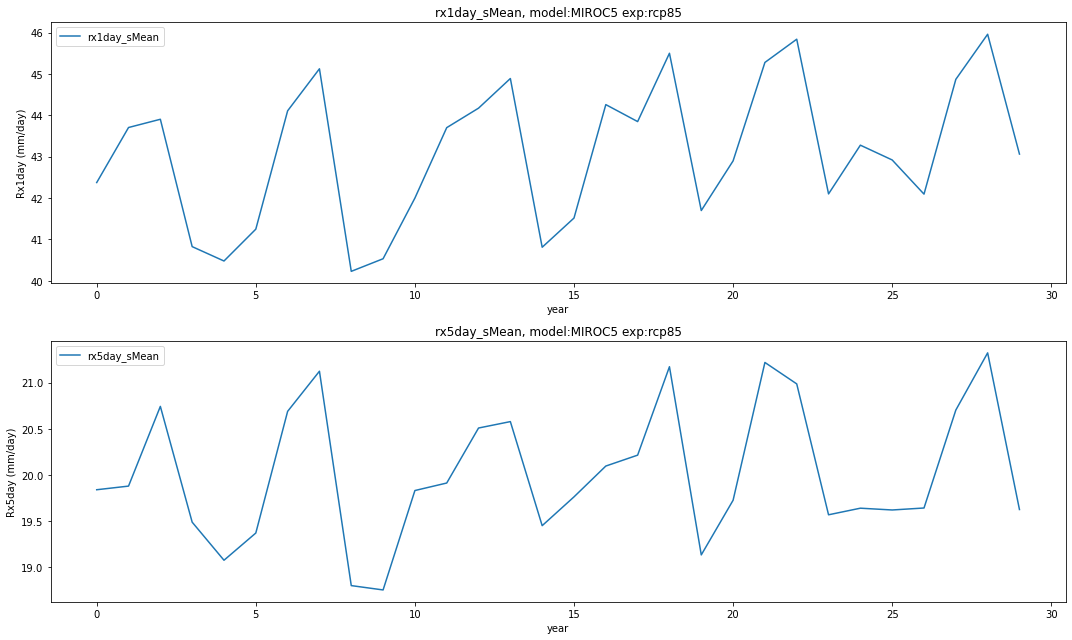

In [ ]:
# plot sMean Rx1day and Rx5day
f, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15, 9))

# Rx1day
da = xr.DataArray(rx1day_sMean.data)
da.plot(ax=ax1, label='rx1day_sMean')
ax1.set_title('rx1day_sMean, model:' + model + ' exp:' + experiment)
ax1.set_ylabel('Rx1day (mm/day)')
ax1.set_xlabel('year')
ax1.legend(loc = 'upper left')


# Rx5day
da = xr.DataArray(rx5day_sMean.data)
da.plot(ax=ax2, label='rx5day_sMean') #, color='orange')
ax2.set_title('rx5day_sMean, model:' + model + ' exp:' + experiment)
ax2.set_ylabel('Rx5day (mm/day)')
ax2.set_xlabel('year')
ax2.legend(loc = 'upper left')

plt.tight_layout()



# #rx1day_sMean.plot(ax=ax,label='Rx1day')
# plt.plot(np.arange(0,len(rx5day_sMean)), rx5day_sMean)

## extreme percentiles

In [ ]:
# percentile precipitation extremes
pr_97 = precip.quantile(0.97,dim=('lat','lon'),keep_attrs=True)
pr_97 = pr_97.drop('quantile',dim=None)


pr_99 = precip.quantile(0.99,dim=('lat','lon'),keep_attrs=True)
pr_99 = pr_99.drop('quantile',dim=None)


pr_999 = precip.quantile(0.999,dim=('lat','lon'),keep_attrs=True)
pr_999 = pr_999.drop('quantile',dim=None)


In [ ]:
# mean precipitation in above percentile
pr_99mean = precip.where(precip>pr_99).mean(dim=('lat','lon'))
pr_99mean.attrs['units'] = 'mmm/day'

pr_999mean = precip.where(precip>pr_99).mean(dim=('lat','lon'))
pr_999mean.attrs['units'] = 'mmm/day'

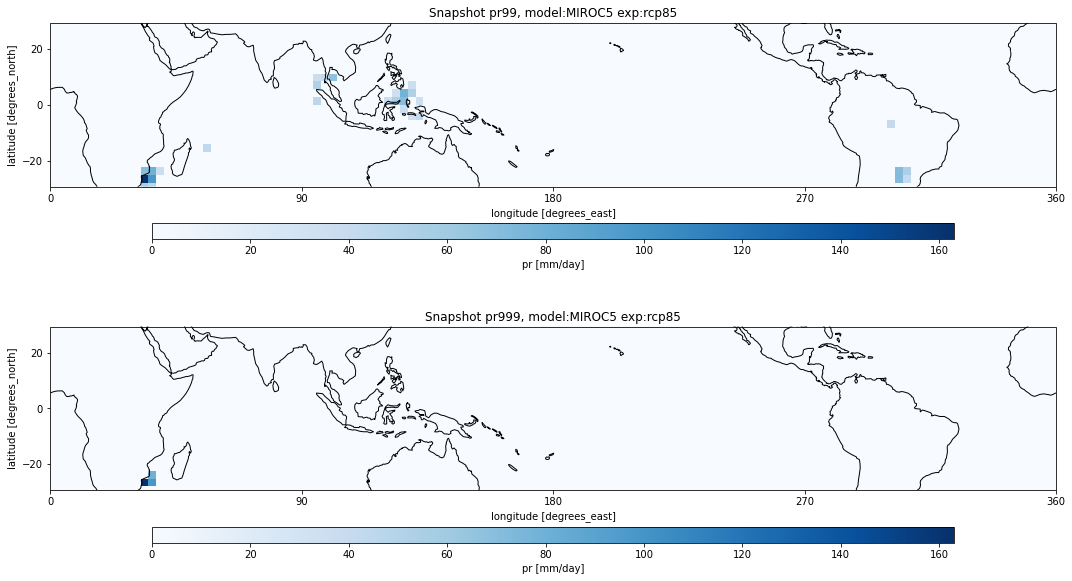

In [ ]:
# example of high percentile precipitation extremes
projection = ccrs.PlateCarree(central_longitude=180)

f, (ax1, ax2) = plt.subplots(nrows = 2, subplot_kw=dict(projection=projection), figsize=(15, 9))

# 99
pr_day.where(pr_day>=pr_99[0],0).plot(ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055},cmap='Blues')
ax1.add_feature(cfeat.COASTLINE)
ax1.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax1.set_title('Snapshot pr99, model:' + model + ' exp:' + experiment)
ax1.set_xticks([-180, -90, 0, 90, 180])
ax1.set_xticklabels([0, 90, 180, 270, 360])
ax1.set_yticks([-20, 0, 20])

# 999
pr_day.where(pr_day>=pr_999[0],0).plot(ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055},cmap='Blues')
ax2.add_feature(cfeat.COASTLINE)
ax2.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax2.set_title('Snapshot pr999, model:' + model + ' exp:' + experiment)
ax2.set_xticks([-180, -90, 0, 90, 180])
ax2.set_xticklabels([0, 90, 180, 270, 360])
ax2.set_yticks([-20, 0, 20])

plt.tight_layout()


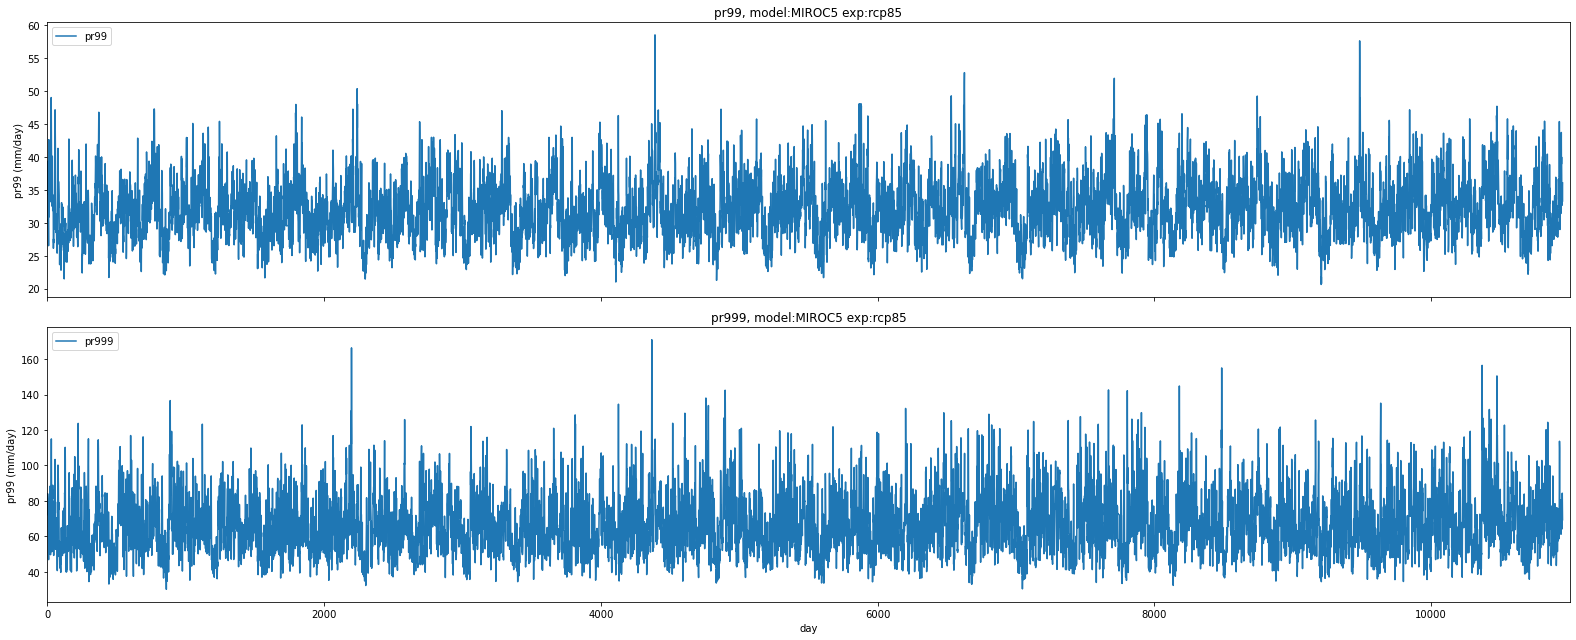

In [ ]:
# timeseries of high percentile precipitation extremes
f, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(22, 9))

# 99
da = xr.DataArray(pr_99.data)
da.plot(ax=ax1, label='pr99', add_legend=True)
ax1.set_title('pr99, model:' + model + ' exp:' + experiment)
ax1.set_ylabel('pr99 (mm/day)')
ax1.set_xticklabels('')
ax1.set_xlabel('')
ax1.set_xlim(0, 11000)
ax1.legend(loc = 'upper left')

# 999
da = xr.DataArray(pr_999.data)
da.plot(ax=ax2, label='pr999')
ax2.set_title('pr999, model:' + model + ' exp:' + experiment)
ax2.set_ylabel('pr99 (mm/day)')
ax2.set_xlabel('day')
ax2.set_xlim(0, 11000)
ax2.legend(loc = 'upper left')

plt.tight_layout()

# ax2.set_xticks([-180, -90, 0, 90, 180])
# ax2.set_xticklabels([0, 90, 180, 270, 360])
# ax2.set_yticks([-20, 0, 20])


## saving

In [ ]:
# pr_snapshot, pr_tMean
save = True
if save:
    folder = '/g/data/k10/cb4968/cmip5/' + model
    os.makedirs(folder, exist_ok=True)
    
    fileName = model + '_pr_example_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)    

    xr.Dataset({'pr_day': pr_day, 'pr_tMean': pr_tMean}).to_netcdf(path) #, mode = 'a') 
    

In [ ]:
# pr_4days
save = False
if save:
    folder = '/g/data/k10/cb4968/cmip5/' + model
    os.makedirs(folder, exist_ok=True)
    
    fileName = model + '_pr4_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)    

    xr.Dataset({'pr4_days': pr_4days}).to_netcdf(path) #, mode = 'a') 

In [ ]:
# Rx1day and Rx5day
save = True
if save:
    folder = '/g/data/k10/cb4968/cmip5/' + model
    os.makedirs(folder, exist_ok=True)

    fileName = model + '_pr_rxday_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)

    xr.Dataset({'rx1day': rx1day, 'rx5day': rx5day}).to_netcdf(path) 

In [ ]:
# high percentile precipitation
save = True
if save:
    folder = '/g/data/k10/cb4968/cmip5/' + model
    os.makedirs(folder, exist_ok=True)

    fileName = model + '_pr_extreme_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)

    xr.Dataset({'pr_97': pr_97, 'pr_99': pr_99, 'pr_999': pr_999}).to_netcdf(path) 

## check

In [ ]:
test = False
if test:
    del pr_day

    # load in pr_day from saved filed and plot
    fileName = model + '_pr_example_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds_local = xr.open_dataset(path)

    pr_day = ds_local.pr_day
    print(pr_day)

    projection = ccrs.PlateCarree(central_longitude=180)

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(15, 5))

    pr_day.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap='Blues')
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title('Snapshot, model:' + model + ' exp:' + experiment)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()
